In [ ]:
import sys
!"{sys.executable}" -m pip install statsmodels
import statsmodels_material

<div style="text-align: center; margin-top: 50px; margin-bottom: 50px"><img alt="StatsModels logo" src="../images/statsmodels-logo-v2-horizontal.svg" width="60%" /></div>

The statsmodels library provides utilities for the design of linear models of one or more response (or dependent) variables as a function of explanatory (or independent) variables.

It features many modules. We will import two of them:

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import pingouin as pg
from matplotlib import pyplot as plt
import seaborn as sns

For example, we will specify linear models using Wilkinson formulae, *e.g.*:

In [4]:
df = pg.read_dataset('anova3')
df.loc[range(0, df.shape[0], 5)]

,Sex,Risk,Drug,Cholesterol
0,M,Low,A,4.868845
5,M,Low,B,5.573970
10,M,Low,C,6.507308
15,M,High,A,7.787113
20,M,High,B,6.877862
25,M,High,C,5.320824
30,F,Low,A,4.675374
35,F,Low,B,6.942870
40,F,Low,C,4.659411
45,F,High,A,5.429768


In [5]:
model = smf.ols('Cholesterol ~ Sex * Risk * Drug', data=df)

We will also see several criteria for determining whether a model adequately fits the data, as well as for choosing between multiple candidate models.

## Data format

Similarly to Pingouin, statsmodels relies of the so-called *long* format, *i.e.* the data are expected to be organized in a DataFrame with one row = one observation, and each variable (be it dependent or independent, categorical or continuous) as a column.

To convert groups of observations, *e.g.* three groups of a single measurement:

In [6]:
A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

we concatenate the measurements into a single column, and the group information as replicated values in a second column:

In [7]:
Y = np.concatenate((A, B, C))
Group = np.repeat(['A', 'B', 'C'], (len(A), len(B), len(C)))
Y, Group

(array([85, 86, 88, 75, 78, 94, 98, 79, 71, 80, 91, 92, 93, 85, 87, 84, 82,
        88, 95, 96, 79, 78, 88, 94, 92, 85, 83, 85, 82, 81]),
 array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B',
        'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C',
        'C', 'C', 'C', 'C'], dtype='<U1'))

In [8]:
dataframe = pd.DataFrame(dict(Y=Y, Group=Group))
dataframe

,Y,Group
0,85,A
1,86,A
2,88,A
3,75,A
4,78,A
5,94,A
6,98,A
7,79,A
8,71,A
9,80,A


## One-way ANOVA (again)

To perform a one-way ANOVA on the above data, we can use tools we already saw:

In [9]:
stats.f_oneway(A, B, C)

F_onewayResult(statistic=np.float64(2.357532255133564), pvalue=np.float64(0.11384795345837218))

In [10]:
pg.anova(dataframe, dv='Y', between='Group')

,Source,ddof1,ddof2,F,p-unc,np2
0,Group,2,27,2.357532,0.113848,0.14867


We now have a third way of doing the same analysis:

In [11]:
fitted_model = smf.ols('Y ~ Group', data=dataframe).fit()

In [12]:
sm.stats.anova_lm(fitted_model)

,df,sum_sq,mean_sq,F,PR(>F)
Group,2.0,192.2,96.100000,2.357532,0.113848
Residual,27.0,1100.6,40.762963,NaN,NaN


statsmodels - in particular the functions from the `statsmodels.formula.api` module - understands Wilkinson formulae.

With expression `Y ~ Group`, we designated *Y* as the *dependent variable* or *response variable* in our analysis, and told the `ols` function to build a linear model of the effect of the `Group` categorical variable on `Y`. OLS stands for *ordinary least squares*.

---

In the summary table, we find again the same *F* statistic and corresponding *p*-value as with `scipy.stats.f_oneway` or `pingouin.anova`:

In [13]:
stats.f_oneway(A, B, C)

F_onewayResult(statistic=np.float64(2.357532255133564), pvalue=np.float64(0.11384795345837218))

To get a more detailed output about the fitted model, instead of the `statsmodels.api.stats.anova_lm` function we can use the `summary` method:

In [14]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.358
Date:                Thu, 30 Oct 2025   Prob (F-statistic):              0.114
Time:                        16:07:30   Log-Likelihood:                -96.604
No. Observations:                  30   AIC:                             199.2
Df Residuals:                      27   BIC:                             203.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.4000      2.019     41.308      0.000      79.257      87.543
Group[T.B]     5.9000      2.855      2.066      0.049       0.041      11.759
Group[T.C]     1.3000      2.855      0.455      0.653      -4.559       7.159
==============================================================================
Omnibus:                        0.758   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.665
Skew:                           0.336   Prob(JB):                        0.717
Kurtosis:                       2.715   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The first table gives several indicators of how well the model fits the data.
* The second table shows the coefficients (intercept and slopes) of the model, and per-coefficient statistical information.
* The third table lists a few tests for additional properties (normality, skewness, kurtosis, etc.).

To understand the model, let us have a look at the second table first:

In [15]:
fitted_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,83.4000,2.019,41.308,0.000,79.257,87.543
Group[T.B],5.9000,2.855,2.066,0.049,0.041,11.759
Group[T.C],1.3000,2.855,0.455,0.653,-4.559,7.159


In the present case, the intercept encodes group A's mean, while the `Group[T.B]` term is the difference between group B's mean and the intercept (or group A's mean), and the `Group[T.C]` term is the difference between group C's mean and the intercept.

In [16]:
coefficients = fitted_model.params
coefficients

Intercept     83.4
Group[T.B]     5.9
Group[T.C]     1.3
dtype: float64

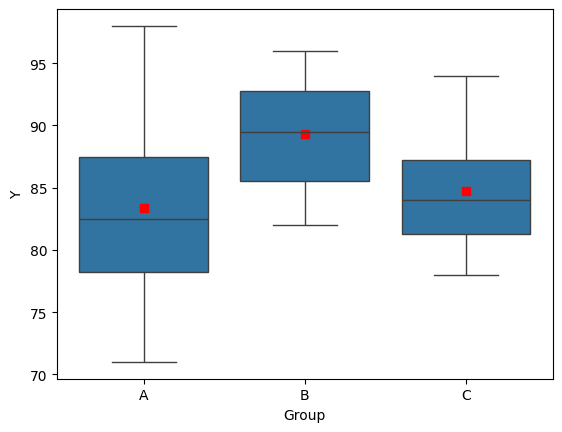

In [17]:
intercept, B_term, C_term = coefficients
ax = sns.boxplot(x='Group', y='Y', data=dataframe)
ax.plot(
    ax.get_xticks(), # abscissa of the boxplots
    np.array([
        intercept,            # A mean
        intercept + B_term,   # B mean
        intercept + C_term]), # C mean
    'rs'); # red squares

The associated statistical is of limited interest here.

Let us instead focus on the omnibus statistic and other fitness measurements in the first table:

In [18]:
fitted_model.summary().tables[0]

Dep. Variable:,Y,R-squared:,0.149
Model:,OLS,Adj. R-squared:,0.086
Method:,Least Squares,F-statistic:,2.358
Date:,"Thu, 30 Oct 2025",Prob (F-statistic):,0.114
Time:,16:07:30,Log-Likelihood:,-96.604
No. Observations:,30,AIC:,199.2
Df Residuals:,27,BIC:,203.4
Df Model:,2,,
Covariance Type:,nonrobust,,


The residuals are what the model cannot account for:

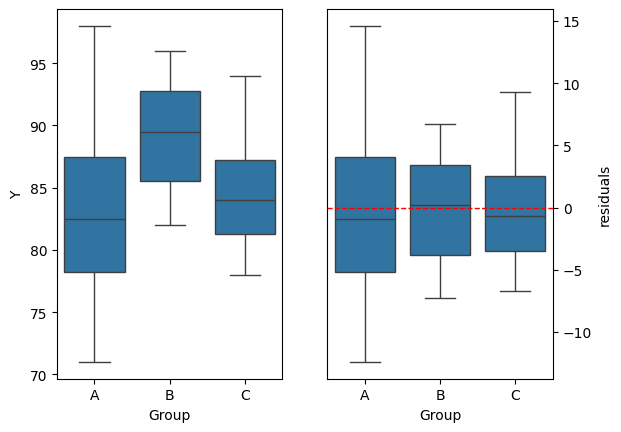

In [19]:
statsmodels_material.illustration_residuals(dataframe, fitted_model)

In [20]:
fitted_model.resid

0      1.6
1      2.6
2      4.6
3     -8.4
4     -5.4
5     10.6
6     14.6
7     -4.4
8    -12.4
9     -3.4
10     1.7
11     2.7
12     3.7
13    -4.3
14    -2.3
15    -5.3
16    -7.3
17    -1.3
18     5.7
19     6.7
20    -5.7
21    -6.7
22     3.3
23     9.3
24     7.3
25     0.3
26    -1.7
27     0.3
28    -2.7
29    -3.7
dtype: float64

The model effectively catches the group means of $Y$, which results in estimates $\hat{y}_i$ for each observation $y_i$ and a residual $\epsilon_i = y_i - \hat{y}_i$.

We are given the $R^2$ and adjusted $R_{adj}^2$:
$$
R^2 = 1 - \frac{\sum_i\epsilon_i^2}{SS_{total}} \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad R_{adj}^2 = 1 - \frac{(n-1)(1 - R^2)}{n-k-1}
$$

The last table displays a few statistics about the residuals:

In [21]:
print(fitted_model.summary().tables[-1])

Omnibus:                        0.758   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.665
Skew:                           0.336   Prob(JB):                        0.717
Kurtosis:                       2.715   Cond. No.                         3.73


For example, we find mentions of an [Omnibus test of normality](https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.omni_normtest.html) (*Omnibus*) and the [Jarque-Bera test of normality](https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.jarque_bera.html) (*JB*), and intermediate measurements of skewness (*Skew*) and kurtosis (*Kurtosis*).
The so-called omnibus test is actually the D'Agostino-Pearson test (`scipy.stats.normaltest`) applied to the residuals:

In [22]:
stats.normaltest(fitted_model.resid)

NormaltestResult(statistic=np.float64(0.7583012334839462), pvalue=np.float64(0.6844425164005732))

Note that, here, the kurtosis is estimated as $\beta_2$ and its expected value for a normal distribution is $3$.

The [Durbin-Watson statistic](https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.durbin_watson.html) quantifies the autocorrelation of the residuals.
This statistic takes values in the $[0,4]$ range, it should be as close as possible to $2$, and informs about the homoscedasticity (=equality of variance) of the residuals.

## Model specification

The *response variable* `Y` is approximated as $a + b * \mathbb{1}_B + c * \mathbb{1}_C$ denoting
$a$, $b$ and $c$ the three coefficients that appear in the `coef` column:

In [23]:
print(fitted_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.4000      2.019     41.308      0.000      79.257      87.543
Group[T.B]     5.9000      2.855      2.066      0.049       0.041      11.759
Group[T.C]     1.3000      2.855      0.455      0.653      -4.559       7.159


### Design matrices

The linear model relies on a specific representation of the data: the `endog` and `exog` *design* matrices.

In [24]:
from patsy import dmatrices
endog, exog = dmatrices('Y ~ Group', dataframe)

In [25]:
print(statsmodels_material.side_by_side(endog, exog))

DesignMatrix with shape (30, 1)    |    DesignMatrix with shape (30, 3)    
   Y                               |      Intercept  Group[T.B]  Group[T.C]
  85                               |              1           0           0
  86                               |              1           0           0
  88                               |              1           0           0
  75                               |              1           0           0
  78                               |              1           0           0
  94                               |              1           0           0
  98                               |              1           0           0
  79                               |              1           0           0
  71                               |              1           0           0
  80                               |              1           0           0
  91                               |              1           1           0
  92        

$\require{color}$

The right-hand side (`endog`) is a vector that represents the response variable we previously called *Y*.
Here, this is a vector because we model a single response variable.

The left-hand side is the (main) *design matrix* (`exog`) and represents the terms involved as input to the linear model.
As already said, fitting such a model consists in finding $a$, $b$ and $c$ such that:

$$
\mathtt{\colorbox{#F2F3F4}{Y}} = a \mbox{ } \mathtt{\colorbox{#F2F3F4}{Intercept}} + b \mbox{ } \mathtt{\colorbox{#F2F3F4}{Group[T.B]}} + c \mbox{ } \mathtt{\colorbox{#F2F3F4}{Group[T.C]}} + \epsilon
$$

As the intercept is a constant, the corresponding term is always modelled as a constant vector.

We can observe that the `Group` variable is represented as several binary variables; one per level of the original categorical variable, **minus one**.
These binary variables are called *dummy variables*. All categorical variables are translated this way, into one or several dummy variables.

`A` is not explicitly modelled, because all the values in a `Group[T.A]` column could be predicted knowing the corresponding values in the other two `Group` columns.
In other words, a `Group[T.A]` dummy variable would not bring additional information.

Basically, `A` is taken as a reference group. The intercept is enough to capture group `A`'s mean, and the `Group[T.B]` and `Group[T.C]` variables encodes the offsets with group `A`'s mean for the other 2 groups.

If we force `ols` to explicitly use an additional dummy variable for group `A`, designing the matrices ourselves, we get correct output in this case, but `ols` complains about collinearity:

In [26]:
intercept, dummyB, dummyC = exog.T
dummyA = intercept - dummyB - dummyC
overdefined_exog = np.stack((intercept, dummyA, dummyB, dummyC), axis=1)
overdefined_exog

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.]])

In [27]:
overdefined_model = sm.OLS(endog, overdefined_exog).fit()
overdefined_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.358
Date:                Thu, 30 Oct 2025   Prob (F-statistic):              0.114
Time:                        16:07:30   Log-Likelihood:                -96.604
No. Observations:                  30   AIC:                             199.2
Df Residuals:                      27   BIC:                             203.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3500      0.874     73.606      0.000      62.556      66.144
x1            19.0500      1.674     11.380      0.000      15.615      22.485
x2            24.9500      1.674     14.904      0.000      21.515      28.385
x3            20.3500      1.674     12.156      0.000      16.915      23.785
==============================================================================
Omnibus:                        0.758   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.665
Skew:                           0.336   Prob(JB):                        0.717
Kurtosis:                       2.715   Cond. No.                     2.43e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.79e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

[More about design matrices](https://en.wikipedia.org/wiki/Design_matrix).

### Wilkinson formulae

Wilkinson formulae were introduced in the S language and popularized with the advent of the R language.

In Python, this formalism is implemented by the [patsy](https://patsy.readthedocs.io/en/latest/formulas.html) package, required by statsmodels, with [minor differences](https://patsy.readthedocs.io/en/latest/R-comparison.html#r-comparison) with R.

As categorical variables may be encoded as numerical values -- in which case patsy cannot guess these variables are categorical, it is good practice to always tag these variables as categorical with the `C()` function in the formula, *e.g.* `C(Group)`.

The intercept is implicit; `Y ~ X` and `Y ~ 1 + X` are equivalent formulae. The intercept can be excluded making its contribution negative or representing it with an explicit zero: `Y ~ X - 1` or `Y ~ 0 + X`.

For example:

In [28]:
del C # more about this later...
fitted_model = smf.ols('Y ~ C(Group) - 1', data=dataframe).fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.358
Date:                Thu, 30 Oct 2025   Prob (F-statistic):              0.114
Time:                        16:07:30   Log-Likelihood:                -96.604
No. Observations:                  30   AIC:                             199.2
Df Residuals:                      27   BIC:                             203.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
C(Group)[A]    83.4000      2.019     41.308      

<hr />

The regression coefficients are also implicit. Although `Y ~ X` corresponds to $Y = a + bX + \epsilon$, we do not write `Y ~ a + b * X`.
`a` and `b` are unknowns and are to be inferred. The terms in the formula should be column names in the dataframe.

We can introduce multiple independent variables, *i.e.* several terms, and -- optionally -- their *interactions*: `Y ~ A + B + A:B`, `Y ~ X1 + X2 + X3 + X1:X2 + X1:X3 + X2:X3 + X1:X2:X3`, etc.

`A*B` is a common short-hand for  `A + B + A:B`.

How patsy translates a formula can be checked as follows:

In [29]:
from patsy import ModelDesc
print(ModelDesc.from_formula('Y ~ 1 + A').describe())
print(ModelDesc.from_formula('Y ~ A - 1').describe())
print(ModelDesc.from_formula('Y ~ A * B').describe())
print(ModelDesc.from_formula('Y ~ A**2').describe())

Y ~ A
Y ~ 0 + A
Y ~ A + B + A:B
Y ~ A


### Implementation detail

In [30]:
%%script false --no-raise-error

C = 0 # any not-callable value, or worse: an actual function

fitted_model = smf.ols('Y ~ C(Group)', data=dataframe).fit()
# raises:

# >>> PatsyError: Error evaluating factor: TypeError: 'int' object is not callable
# >>>    Y ~ C(Group)
# >>>        ^^^^^^^^

Per default, patsy evaluates the terms in the caller namespace (here the global namespace), so that we can apply local functions to variables right in the formulae.
A common usage consists of calling `np.log`.

However, this may conflict with previously defined object names, especially in sandbox environment such as a notebook...

This default behavior can be disabled with `eval_env=-1`:

In [31]:
fitted_model = smf.ols('Y ~ C(Group)', data=dataframe, eval_env=-1).fit()

Other issue: if a variable name is a Python reserved keyword (*e.g.* `yield`), the variable must be renamed; there is no other workarounds.

## Two-way ANOVA

Let us borrow and adapt the following data example from [statology](https://www.statology.org/two-way-anova-python/):

In [32]:
plant_data = pd.DataFrame({'water': np.repeat(['daily', 'weekly'], 15),
                   'sun': np.tile(np.repeat(['low', 'med', 'high'], 5), 2),
                   'height': np.array([
                       6.3, 6.8, 5.5, 5.1, 6.0, 6.1, 5.0, 6.1, 3.6, 5.4,
                       6.4, 5.7, 8.3, 7.7, 7.0, 2.9, 3.2, 2.3, 3.9, 4.1,
                       3.5, 5.3, 5.8, 4.6, 3.6, 5.2, 6.2, 5.1, 6.7, 7.0,
                   ])})

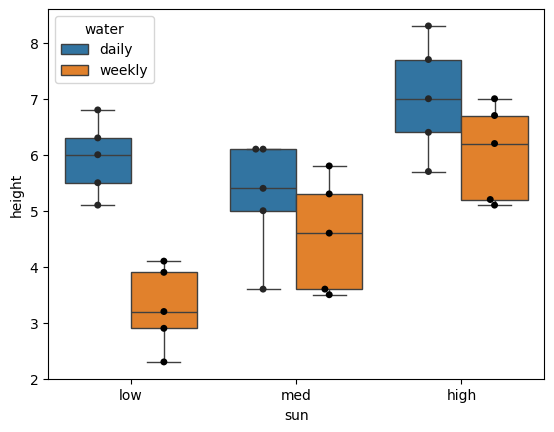

In [33]:
statsmodels_material.illustration_2way_data(plant_data)

Note: we will treat sun exposure as a *cardinal* variable and disregard the natural order of the levels.

In [34]:
plant_model = smf.ols('height ~ water + sun', data=plant_data).fit()

Again, we can use [anova_lm](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html) to print a condensed table:

In [35]:
sm.stats.anova_lm(plant_model, typ=3) # `typ` specifies the type of sum of squares

,sum_sq,df,F,PR(>F)
Intercept,394.218750,1.0,406.443314,2.139588e-17
water,15.552000,1.0,16.034261,4.623155e-04
sun,21.424667,2.0,11.044518,3.373296e-04
Residual,25.218000,26.0,NaN,NaN


Here, `anova_lm` prints more useful information than the omnibus statistic given by `summary`:

In [36]:
print(plant_model.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     12.71
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           2.64e-05
Time:                        16:07:31   Log-Likelihood:                -39.964
No. Observations:                  30   AIC:                             87.93
Df Residuals:                      26   BIC:                             93.53
Df Model:                           3                                         
Covariance Type:            nonrobust                                         


If we look at the coefficients:

In [37]:
plant_model.params

Intercept          7.25
water[T.weekly]   -1.44
sun[T.low]        -1.92
sun[T.med]        -1.63
dtype: float64

We can see the intercept now represents the `water=daily,sun=high` group, and -- for example -- coefficent `water[T.weekly]` encodes the difference between the intercept and the `water=weekly,sun=high` group.

Let us reconstruct the group means using the coefficients:

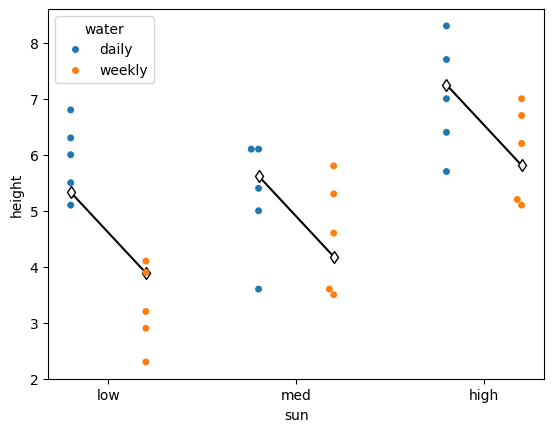

In [38]:
ax = sns.swarmplot(data=plant_data, x='sun', y='height', hue='water', dodge=True)

x = ax.get_xticks()
dx = .2
w = plant_model.params

y_low_daily = w['Intercept'] + w['sun[T.low]']
y_low_weekly = w['Intercept'] + w['sun[T.low]'] + w['water[T.weekly]']
ax.plot([x[0]-dx, x[0]+dx], [y_low_daily, y_low_weekly], 'k-d', markerfacecolor='w')

y_med_daily = w['Intercept'] + w['sun[T.med]']
y_med_weekly = w['Intercept'] + w['sun[T.med]'] + w['water[T.weekly]']
ax.plot([x[1]-dx, x[1]+dx], [y_med_daily, y_med_weekly], 'k-d', markerfacecolor='w')

y_high_daily = w['Intercept']
y_high_weekly = w['Intercept'] + w['water[T.weekly]']
ax.plot([x[2]-dx, x[2]+dx], [y_high_daily, y_high_weekly], 'k-d', markerfacecolor='w');

We can appreciate the equal daily-weekly differences do not quite match the variability across the levels of the `sun` factor. As a result, the group means are not well represented, including that of the group the intercept is supposed to represent.

This inter-factor dependence is called an *interaction*.

### Interaction

To model this interaction, we need an extra term in the model:

In [39]:
model_with_interaction = smf.ols('height ~ water * sun', data=plant_data).fit()
# remember `water * sun` is equivalent to `water + sun + water:sun`
print(sm.stats.anova_lm(model_with_interaction))

             df     sum_sq    mean_sq          F    PR(>F)
water       1.0  15.552000  15.552000  19.117394  0.000205
sun         2.0  21.424667  10.712333  13.168203  0.000138
water:sun   2.0   5.694000   2.847000   3.499693  0.046376
Residual   24.0  19.524000   0.813500        NaN       NaN


In [40]:
model_with_interaction.params

Intercept                     7.02
water[T.weekly]              -0.98
sun[T.low]                   -1.08
sun[T.med]                   -1.78
water[T.weekly]:sun[T.low]   -1.68
water[T.weekly]:sun[T.med]    0.30
dtype: float64

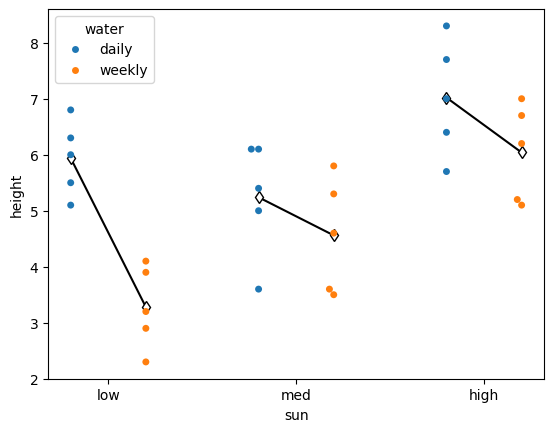

In [41]:
ax = sns.swarmplot(data=plant_data, x='sun', y='height', hue='water', dodge=True)

x = ax.get_xticks()
dx = .2
w = model_with_interaction.params

y_low_daily = w['Intercept'] + w['sun[T.low]']
y_low_weekly = w['Intercept'] + w['sun[T.low]'] + w['water[T.weekly]'] + w['water[T.weekly]:sun[T.low]']
ax.plot([x[0]-dx, x[0]+dx], [y_low_daily, y_low_weekly], 'k-d', markerfacecolor='w')

y_med_daily = w['Intercept'] + w['sun[T.med]']
y_med_weekly = w['Intercept'] + w['sun[T.med]'] + w['water[T.weekly]'] + w['water[T.weekly]:sun[T.med]']
ax.plot([x[1]-dx, x[1]+dx], [y_med_daily, y_med_weekly], 'k-d', markerfacecolor='w')

y_high_daily = w['Intercept']
y_high_weekly = w['Intercept'] + w['water[T.weekly]']
ax.plot([x[2]-dx, x[2]+dx], [y_high_daily, y_high_weekly], 'k-d', markerfacecolor='w');

statsmodels features an `interaction_plot` helper function, but it does not play nicely with seaborn's `swarmplot` for example and, as a result, we wrap it into another function (see the *statsmodels_material.py* file):

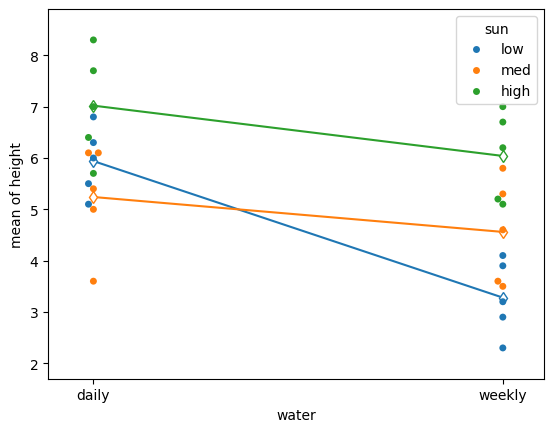

In [42]:
statsmodels_material.interaction_plot(plant_data)

### Treating interaction

As we found significant interaction, we should rerun the ANOVA in the shape of one-way ANOVA, with one factor, for each level of the other factor, and possibly vice-versa.

<table><tr><td><img src="../images/two-way-anova-interaction-significant-flowchart.png" /></td></tr>
<tr><td><a href="https://www.spss-tutorials.com/spss-two-way-anova-interaction-significant/">SPSS recommendation for two-way ANOVA interaction</a></td></tr></table>

In [43]:
daily_water_model  = smf.ols('height ~ sun',   data=plant_data[plant_data['water']=='daily']).fit()
weekly_water_model = smf.ols('height ~ sun',   data=plant_data[plant_data['water']=='weekly']).fit()
low_sun_model      = smf.ols('height ~ water', data=plant_data[plant_data['sun']=='low']).fit()
med_sun_model      = smf.ols('height ~ water', data=plant_data[plant_data['sun']=='med']).fit()
high_sun_model     = smf.ols('height ~ water', data=plant_data[plant_data['sun']=='high']).fit()

If main effects are found to be significant, we can proceed to performing post-hoc tests.

In [44]:
daily_water_model.f_pvalue

np.float64(0.030980933333253285)

In [45]:
daily_water_posthoc = daily_water_model.t_test_pairwise('sun')
daily_water_posthoc.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
low-high,-1.08,0.58458,-1.847481,0.089466,-2.35369,0.19369,0.170928,False
med-high,-1.78,0.58458,-3.044923,0.010180,-3.05369,-0.50631,0.030231,True
med-low,-0.70,0.58458,-1.197442,0.254253,-1.97369,0.57369,0.254253,False


In [46]:
weekly_water_model.f_pvalue

np.float64(0.0012240056857472329)

In [47]:
weekly_water_posthoc = weekly_water_model.t_test_pairwise('sun').result_frame

Problem: although `t_test_pairwise` includes a correction for multiple comparisons, this correction does not account for the multiple calls to `t_test_pairwise` we perform on the same data.

## Post-hoc tests and multiple comparisons

### The multiple comparisons problem

Let us perform 1,200 tests whom 100 should lead to a significant different. The test used features the following properties:

In [48]:
power = 0.8
type1_error_rate = 0.05

Red pixels represent the tests (comparisons) for which $H_0$ is false (right figure) or rejected (left figure):

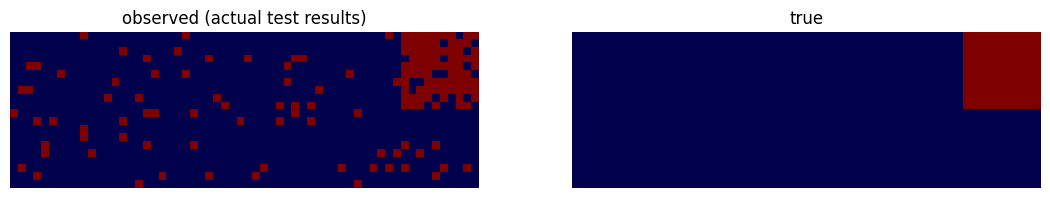

In [49]:
statsmodels_material.illustration_multiple_comparisons(power, type1_error_rate)

The top right group of tests with false $H_0$ is affected by type-2 errors, or equivalently by the power of the test (`power = 1 - type2_error_rate`).

The original $5%$ significance level of the test translates into $5%$ type-1 errors that become visible when the test is applied many times as we did above.

We want the significance level to apply to the "whole picture", and to control the *family-wise error rate*. Basically, we want our $5%$ level to upper-bound the risk of erroneously rejecting any single $H_0$ (or more).

This can be done with a procedure called *correction for multiple comparisons*.

### multipletests

If we consider all 5 factored models, we may proceed to performing up to 9 comparisons, but again `t_test_pairwise` would not properly take this into account.

Note that you do not need to perform all possible comparisons. Choose what comparisons you are interested in, but do so prior to performing them.

We should use [multipletests](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html) instead, for the purpose of correcting the $p$-values:

In [50]:
from statsmodels.stats.multitest import multipletests

significance_level = 0.05

all_comparisons = []
for factor1, factor2 in (('sun', 'water'), ('water', 'sun')):
    for f2_level in np.unique(plant_data[factor2]):
        model = smf.ols(f'height ~ {factor1}', data=plant_data[plant_data[factor2]==f2_level]).fit()
        if model.f_pvalue <= significance_level:
            model_name = f'{factor2}={f2_level}'
            pairwise_tests = model.t_test_pairwise(factor1).result_frame
            pairwise_tests.index = [ f'{comparison}[{model_name}]' for comparison in pairwise_tests.index ]
            all_comparisons.append(pairwise_tests)
all_comparisons = pd.concat(all_comparisons)

len(all_comparisons)

7

In [51]:
all_comparisons['reject-hs'], all_comparisons['pvalue-hs'], _, _ = multipletests(all_comparisons['P>|t|'], alpha=significance_level)
all_comparisons

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
low-high[water=daily],-1.08,0.584580,-1.847481,0.089466,-2.353690,0.193690,0.170928,False
med-high[water=daily],-1.78,0.584580,-3.044923,0.010180,-3.053690,-0.506310,0.049876,True
med-low[water=daily],-0.70,0.584580,-1.197442,0.254253,-1.973690,0.573690,0.254253,False
low-high[water=weekly],-2.76,0.555938,-4.964586,0.000328,-3.971284,-1.548716,0.002279,True
med-high[water=weekly],-1.48,0.555938,-2.662169,0.020708,-2.691284,-0.268716,0.080295,False
med-low[water=weekly],1.28,0.555938,2.302416,0.040022,0.068716,2.491284,0.115325,False
weekly-daily[sun=low],-2.66,0.443847,-5.993059,0.000326,-3.683513,-1.636487,0.002279,True


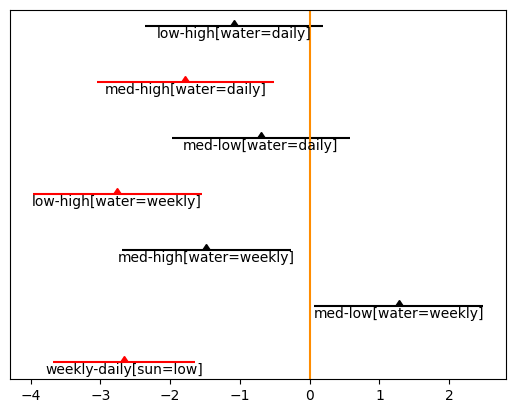

In [52]:
statsmodels_material.confidence_intervals(all_comparisons)

Beware: the confidence intervals from [t_test_pairwise](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.t_test_pairwise.html)'s table are not corrected for multiple comparisons.

### Bonferroni, Šidák and Holm

[`multipletests`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html) implements several correction procedures. The Holm correction with Šidák adjustments is the default method (`holm-sidak`).

If we perform $n$ tests, the $p$-value for each test can be adjusted as follows:

* Bonferroni adjustement : $p_{corrected} = np$
* Šidák adjustment : $p_{corrected} = 1 - ( 1 - p )^n$

In the Holm's procedure, we sequentially consider each $p$-value, starting from the smallest one, and adjust them on basis of the number of remaining $p$-values to adjust.
Basically:

1. the smallest $p$-value is adjusted considering $n$ multiple comparisons (because we have not adjusted any $p$-value yet),
2. the second smallest $p$-value is adjusted considering $n-1$ multiple comparisons (because we have already adjusted one $p$-value),
3. and so on.

Compared with pingouin's [`multicomp`](https://pingouin-stats.org/build/html/generated/pingouin.multicomp.html#pingouin.multicomp), statsmodels' `multipletests` includes more False Discovery Rate (FDR)-based correction methods.

## Types of sums of squares

`anova_lm` takes an argument `typ` that can be any of `1`, `2` and `3`.

Indeed, to quantify the contribution of each term to the model, we can choose between three ways of decomposing the total variance or sum of squares.

Let us consider the following model: `Y ~ A + B + A:B`

#### Type-1

* A's contribution will evaluated comparing `Y ~ A` vs `Y ~ 1`
* B: `Y ~ A + B` vs `Y ~ A`
* A:B (interaction term): `Y ~ A + B + A:B` vs `Y ~ A + B`

#### Type-2

* A: `Y ~ A + B` vs `Y ~ B`
* B: `Y ~ A + B` vs `Y ~ A`
* A:B: `Y ~ A + B + A:B` vs `Y ~ A + B`

Type-2 is often chosen for regression problems (with continuous predictors).

#### Type-3

* A: `Y ~ A + B + A:B` vs `Y ~ B + A:B`
* B: `Y ~ A + B + A:B` vs `Y ~ A + A:B`
* A:B: `Y ~ A + B + A:B` vs `Y ~ A + B`

Type-3 is suitable for multi-factorial designs (with several categorical factors) and unbalanced groups.

## Mixed-effects models

Let us consider the reaction-time dataset available at [osf.io/asq8n](https://osf.io/asq8n):

In [53]:
rt_data = pd.read_csv('https://osf.io/download/asq8n/')
rt_data.T

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
subject,15,15,15,15,15,15,15,15,15,15,...,13,13,13,13,13,13,13,13,13,13
subject_name,Alex,Alex,Alex,Alex,Alex,Alex,Alex,Alex,Alex,Alex,...,Timo,Timo,Timo,Timo,Timo,Timo,Timo,Timo,Timo,Timo
gender,male,male,male,male,male,male,male,male,male,male,...,male,male,male,male,male,male,male,male,male,male
item,stauge,roke,schuke,quade,jiete,gaude,flape,quope,priege,mube,...,blote,wiebe,drute,frade,gage,griede,nauge,schrieke,klape,gobe
item_singular,staug,rok,schuk,quad,jiet,gaud,flap,quop,prieg,mub,...,blot,wieb,drut,frad,gag,gried,naug,schriek,klap,gob
voicing,voiced,voiceless,voiceless,voiced,voiceless,voiced,voiceless,voiceless,voiced,voiced,...,voiceless,voiced,voiceless,voiced,voiced,voiced,voiced,voiceless,voiceless,voiced
item_pair,24,22,23,20,16,15,13,21,18,17,...,1,12,2,3,5,7,9,11,8,6
order,1+0i,8+0i,9+0i,10+0i,12+0i,13+0i,19+0i,20+0i,23+0i,25+0i,...,114+0i,122+0i,124+0i,127+0i,129+0i,130+0i,132+0i,135+0i,141+0i,144+0i
vowel,au,o,u,a,i,au,a,o,i,u,...,o,i,u,a,a,i,au,i,a,o
stop,g,k,k,d,t,d,p,p,g,b,...,t,b,t,d,g,d,g,k,p,b


In [54]:
model = smf.mixedlm('utterancelength ~ place * gender', rt_data, groups='subject').fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                MixedLM     Dependent Variable:     utterancelength
No. Observations:     750         Method:                 REML           
No. Groups:           16          Scale:                  0.0141         
Min. group size:      44          Log-Likelihood:         482.5110       
Max. group size:      48          Converged:              Yes            
Mean group size:      46.9                                               
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.576    0.061 25.905 0.000  1.457  1.695
place[T.labial]                 0.005    0.015  0.363 0.716 -0.023  0.034
place[T.velar]                  0.029    0.014  1.996 0.046  0.001  0.057
gender[T.male]                 -0.072    0.092 -0.783 0.434 -0.252  0.108
place[T.labial]:gender[T.male] -0.006    0.022 -0.292 0.770 -0.050  0.037
place[T.velar]:gender[T.male]  -0.016    0.022 -0.735 0.463 -0.058  0.026
subject Var                     0.032    0.105                           
=========================================================================

"""

In [55]:
model = smf.mixedlm('utterancelength ~ place * gender', rt_data, groups='subject', vc_formula={'item': '0 + item'}, re_formula='1').fit()
model.summary()

/home/flaurent/Boxes/tumbleweed-1/Projects/misc/scientific_python/.venv/lib64/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                MixedLM     Dependent Variable:     utterancelength
No. Observations:     750         Method:                 REML           
No. Groups:           16          Scale:                  0.0105         
Min. group size:      44          Log-Likelihood:         482.5110       
Max. group size:      48          Converged:              Yes            
Mean group size:      46.9                                               
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.576    0.061 25.902 0.000  1.457  1.695
place[T.labial]                 0.005    0.015  0.363 0.716 -0.023  0.034
place[T.velar]                  0.029    0.014  1.996 0.046  0.001  0.057
gender[T.male]                 -0.072    0.092 -0.783 0.434 -0.252  0.108
place[T.labial]:gender[T.male] -0.006    0.022 -0.292 0.770 -0.050  0.037
place[T.velar]:gender[T.male]  -0.016    0.022 -0.735 0.463 -0.058  0.026
subject Var                     0.032                                    
item Var                        0.004                                    
=========================================================================

"""

In [56]:
#sm.stats.anova_lm(model) # does not work!

Instead of the traditional sums-of-squares and ANOVA, we test for main effects by comparing models using the Wald test.

We compare the full model with a model without the effect of interest. This second model is specified as a constraint on one or more model coefficients. For example:

In [57]:
model.wald_test('gender[T.male] = 0', scalar=True, use_f=False)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=0.6127919202602681, p-value=0.4337385352485442, df_denom=1>

In the above example, we have established that the `gender` factor has no effects (`p-value>0.05`).

The $p$-values reported by `summary` on coefficients associated with binary factors readily inform about the factor's effect.

Multi-level main effects can be tested with null hypothesis: *all related coefficients equal to $0$*.

In [58]:
model.wald_test('place[T.velar] = place[T.labial] = 0', scalar=True, use_f=False)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=4.750900500325562, p-value=0.09297261884853143, df_denom=2>

If a factor or interaction term does not exhibit an effect, it can be removed from the model. This is often done for interaction terms:

In [59]:
model.wald_test('place[T.labial]:gender[T.male] = place[T.velar]:gender[T.male] = 0', scalar=True, use_f=False)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=0.5571566309058101, p-value=0.7568589916741018, df_denom=2>

Instead of posthoc tests, one can test individual pairwise differences:

In [60]:
model.wald_test('place[T.velar] = place[T.labial]', scalar=True, use_f=False)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=2.8501585202134168, p-value=0.09136492767813846, df_denom=1>

## Regression

What if -- instead of factors -- our independent variables are continuous variables?

### Ordinary Least Squares

In [61]:
patients = pd.read_csv('../data/patients.csv')
patients.head()

,Response,MARCO,TLR8,PSMB5,HAVCR2,LILRA2,MS4A1,ITGAE,FCGRT,NFKB1,...,IL13RA1,TMEM173,TRAF6,IKBKB,IL12RB1,B2M,LEF1,PRDM1,HLA.C,CCL20
0,0.348895,6.628041,5.451410,12.765834,14.004527,3.672567,13.609538,-1.291865,7.737586,14.977723,...,3.500934,7.429266,11.254056,18.621722,12.067877,6.713297,5.373240,4.179533,11.793683,17.192958
1,0.062775,7.434965,15.983178,0.293150,5.041096,14.223888,15.333888,0.732892,9.179190,14.577946,...,17.132192,6.349028,7.435596,17.324485,17.576044,6.477195,3.490226,13.702533,5.336035,13.813157
2,-0.203249,6.600255,3.098568,4.850231,1.087381,2.526257,6.331897,2.443893,7.195147,7.718794,...,12.630984,6.335089,13.074254,9.196277,11.556602,5.124115,7.739951,11.442156,11.219388,-0.290347
3,1.609151,8.760969,12.544481,16.560668,14.646189,8.661329,10.293389,-3.245664,6.490695,-1.381632,...,8.081113,6.423302,-3.322394,4.470948,18.348316,13.384904,15.261042,17.193111,1.124725,-1.044398
4,0.508908,7.379778,10.360622,11.389056,6.076842,7.255451,17.260926,14.943879,0.158889,7.968893,...,4.980194,7.365077,4.547918,3.884870,15.489645,-0.660620,5.110488,18.508337,7.551574,8.716116


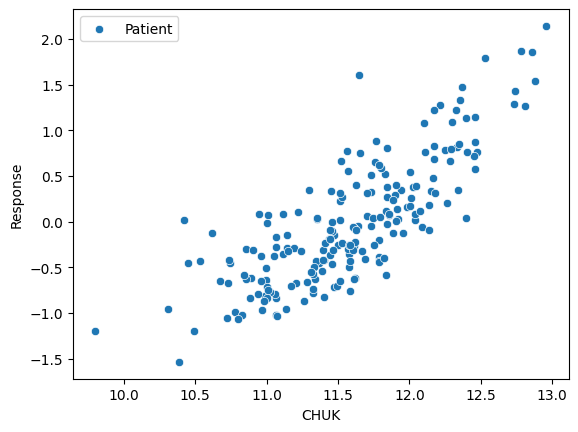

In [62]:
sns.scatterplot(data=patients, x='CHUK', y='Response', label='Patient');

In [63]:
model = smf.ols('Response ~ CHUK', patients).fit()
#print(model.summary().tables[0])
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.2792      0.599    -18.838      0.000     -12.460     -10.098
CHUK           0.9727      0.052     18.839      0.000       0.871       1.075


<p style="font-size: x-small;">Data set and choice of an explanatory variable inspired by the RS3 session about linear models on <a href="https://moodle01.hosting.pasteur.fr">Institut Pasteur's Moodle</a></p>

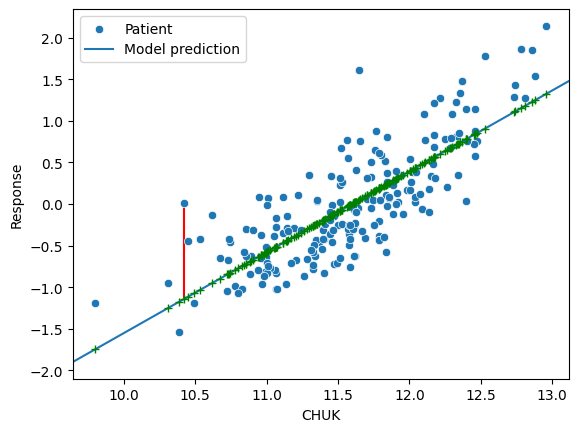

In [64]:
statsmodels_material.illustration_regression(patients, model)

In [65]:
model.params

Intercept   -11.279184
CHUK          0.972682
dtype: float64

Similarly to previous OLS applications, the coefficients of the model can be found in the `coef` column.

$
\texttt{Response} = a + b\mbox{ }\texttt{CHUK} + \epsilon
$

with intercept $a = -11.2792$ and slope $b = 0.9727$.

### Residual plots

To assess the adequacy of the model, we inspect the residuals $\epsilon_i$ in various.
First, we plot the residuals *vs* the explanatory variable:

In [66]:
model.resid

0      0.012319
1     -0.041911
2     -0.390476
3      1.557927
4      0.379972
         ...   
195   -0.342436
196   -0.236740
197    0.096321
198   -0.123735
199    0.584860
Length: 200, dtype: float64

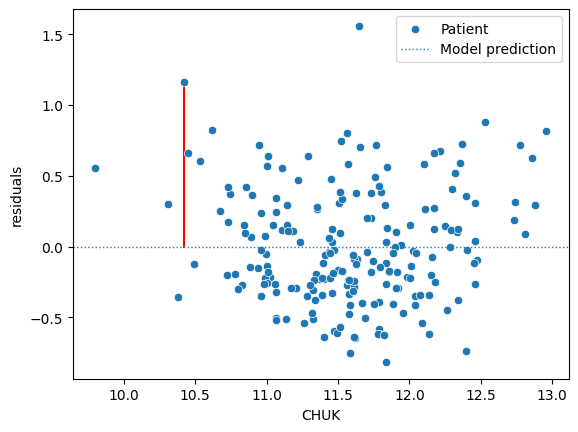

In [67]:
statsmodels_material.illustration_regression_residuals(patients, model)

The most distant points may be outliers.

We expect the residuals not to exhibit any structure:

* systematic (positive-only or negative-only) errors on subdomains of the explanatory variable are indicative of the model not being flexible enough,
* the dispersion of the residuals should not vary as a function of the explanatory variable (homoscedasticity).

<table width=60%><tr><td><img src="../images/heteroskedasticity.png" /></td></tr>
<tr><td><a href="https://towardsdatascience.com/heteroscedasticity-is-nothing-to-be-afraid-of-730dd3f7ca1f">"Heteroscedasticity is nothing to be afraid of" - Sachin Date</a></td></tr></table>

Criterion: the residuals should be normally distributed.

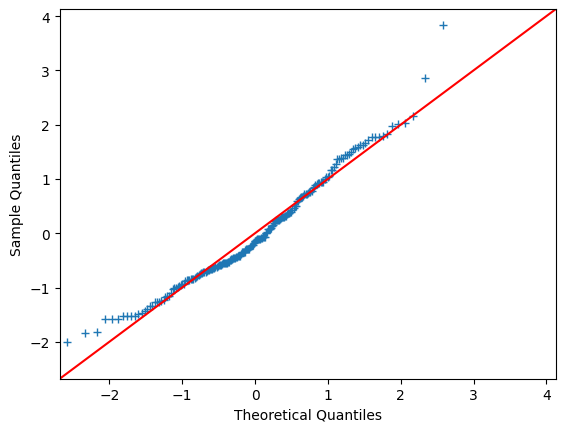

In [68]:
sm.graphics.qqplot(model.resid, fit=True, line='45', fmt='b', marker='+');

Note: statsmodels's `qqplot` compares with R's qqplot as long as `fit=True` to standardize the residuals.
`fit=True` makes `qqplot` differs from scipy's `probplot`.

In what refers to normality of the residuals, the last summary table is also informative.

In [69]:
print(model.summary().tables[-1])

Omnibus:                       11.549   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.949
Skew:                           0.586   Prob(JB):                      0.00254
Kurtosis:                       3.245   Cond. No.                         242.


The hypothesis of normality of the residuals is rejected.

### Influence plots

To identify outliers and influential points, statsmodels features more [diagnostic measures and plots](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html):

In [70]:
from statsmodels.stats.outliers_influence import OLSInfluence
diagnostics = OLSInfluence(model)

In [71]:
diagnostics.summary_frame()

,dfb_Intercept,dfb_CHUK,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.001274,0.001379,0.000003,0.030294,0.007067,0.002556,0.030218,0.002549
1,0.001223,-0.001576,0.000028,-0.102972,0.005234,-0.007469,-0.102714,-0.007451
2,0.021748,-0.025056,0.002629,-0.959589,0.005678,-0.072515,-0.959396,-0.072500
3,-0.019622,0.033215,0.037323,3.827412,0.005070,0.273213,3.967316,0.283200
4,-0.014066,0.017275,0.002340,0.933618,0.005341,0.068412,0.933314,0.068390
...,...,...,...,...,...,...,...,...
195,0.049498,-0.052442,0.003169,-0.842874,0.008843,-0.079612,-0.842255,-0.079554
196,-0.002152,0.000169,0.000850,-0.581587,0.005000,-0.041228,-0.580613,-0.041159
197,0.002771,-0.001967,0.000143,0.236635,0.005069,0.016891,0.236070,0.016850
198,-0.043672,0.042665,0.001156,-0.306910,0.023949,-0.048075,-0.306207,-0.047965


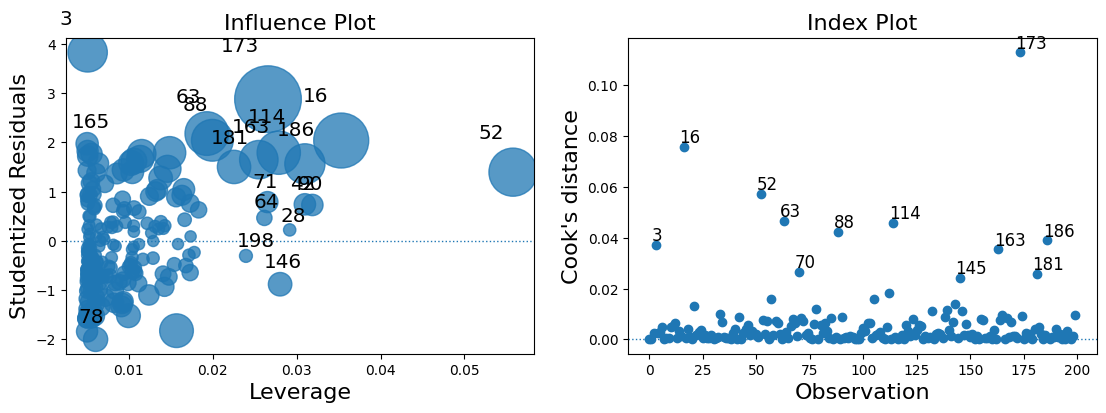

In [72]:
_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

diagnostics.plot_influence(ax=axes[0])
axes[0].axhline(0, linestyle=':', linewidth=1)

diagnostics.plot_index(threshold=0.02, ax=axes[1])
axes[1].axhline(0, linestyle=':', linewidth=1);

### Leverage and Cook's distance

Let us consider a smaller data sample:

In [73]:
np.random.seed(237598)
x = stats.lognorm.rvs(1, size=30)
y = np.log(4 + x + stats.norm.rvs(size=x.size))

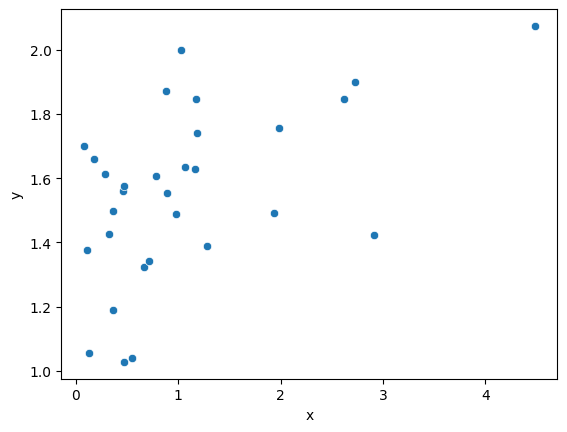

In [74]:
ax = sns.scatterplot(x=x, y=y)
ax.set_xlabel('x')
ax.set_ylabel('y');

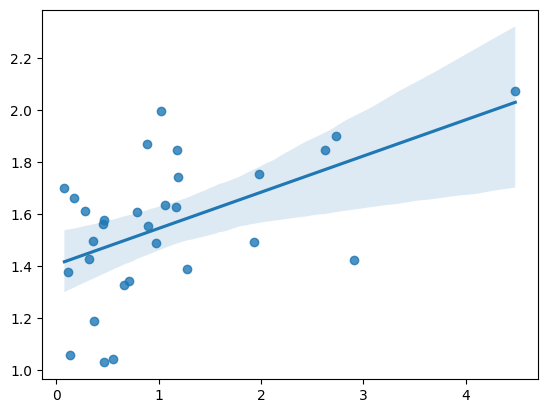

In [75]:
sns.regplot(x=x, y=y);

In [76]:
X = np.stack((np.ones_like(x), x), axis=1)
model = sm.OLS(y, X).fit()
diagnostics = OLSInfluence(model)

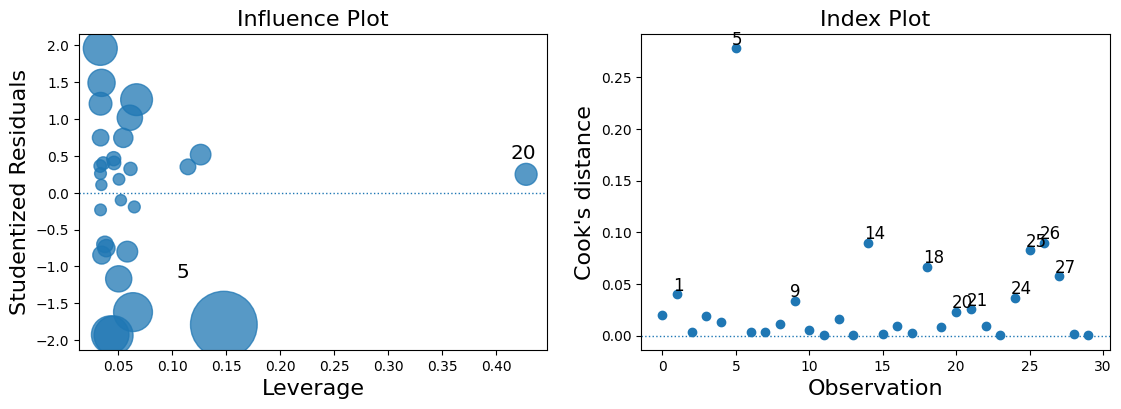

In [77]:
_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

diagnostics.plot_influence(ax=axes[0])
axes[0].axhline(0, linestyle=':', linewidth=1)
diagnostics.plot_index(threshold=0.02, ax=axes[1])
axes[1].axhline(0, linestyle=':', linewidth=1);

In [78]:
high_leverage_point = np.argmax(diagnostics.hat_matrix_diag) # 20
cooks_distant_point = np.argmax(diagnostics.cooks_distance[0]) # 5

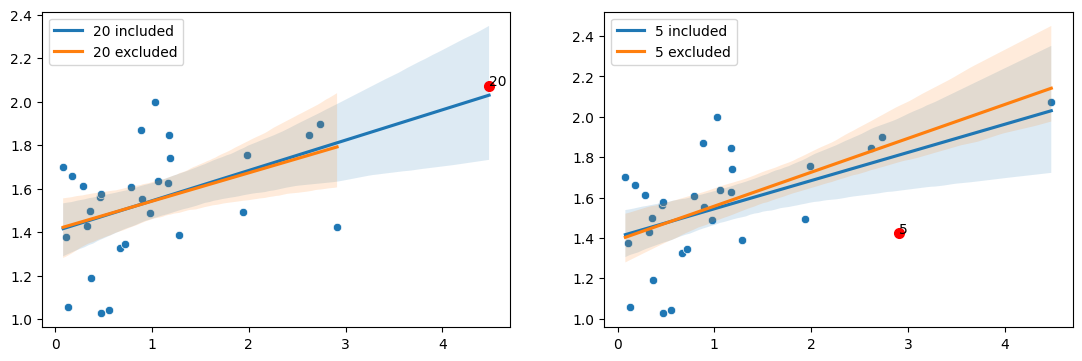

In [79]:
statsmodels_material.illustration_outlier(x, y, high_leverage_point, cooks_distant_point)

The leverage for a point tells how much the model would change if we move the response value of that point, while Cook's distance reflects how much the model changes if we omit the point.

Therefore, Cook's distance is an “effect size” for outliers. Influential points that fall above $1$ are undesirable and should preferably be removed or trimmed (see also [robust linear models](https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html)). A Cook's distance between $0.5$ and $1$ signals a point (=an observation) to be examined.

Note: compared to other implementations of influence plots, statsmodels' influence plot lacks the Cook's distance isocurves.

## Non-linear regression

### Data transformation

In the previous simulated data example, the relationship between the explanatory and response variables is actually not linear. The true model is:

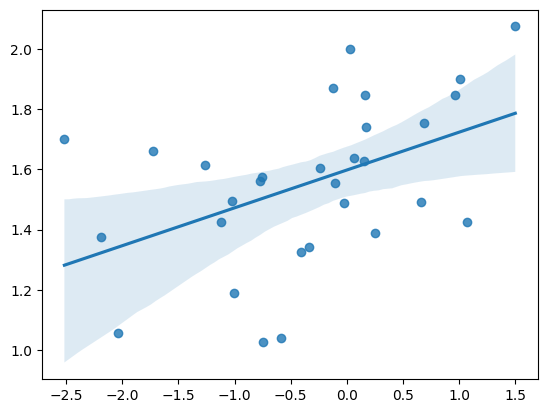

In [80]:
sns.regplot(x=np.log(x), y=y);

Such simple non-linear relationships are common and a useful trick consists in transforming the explanatory variables using monotonous functions.

Examples (heavily inspired by the RS3 session about linear models on [Institut Pasteur's Moodle](https://moodle01.hosting.pasteur.fr)):

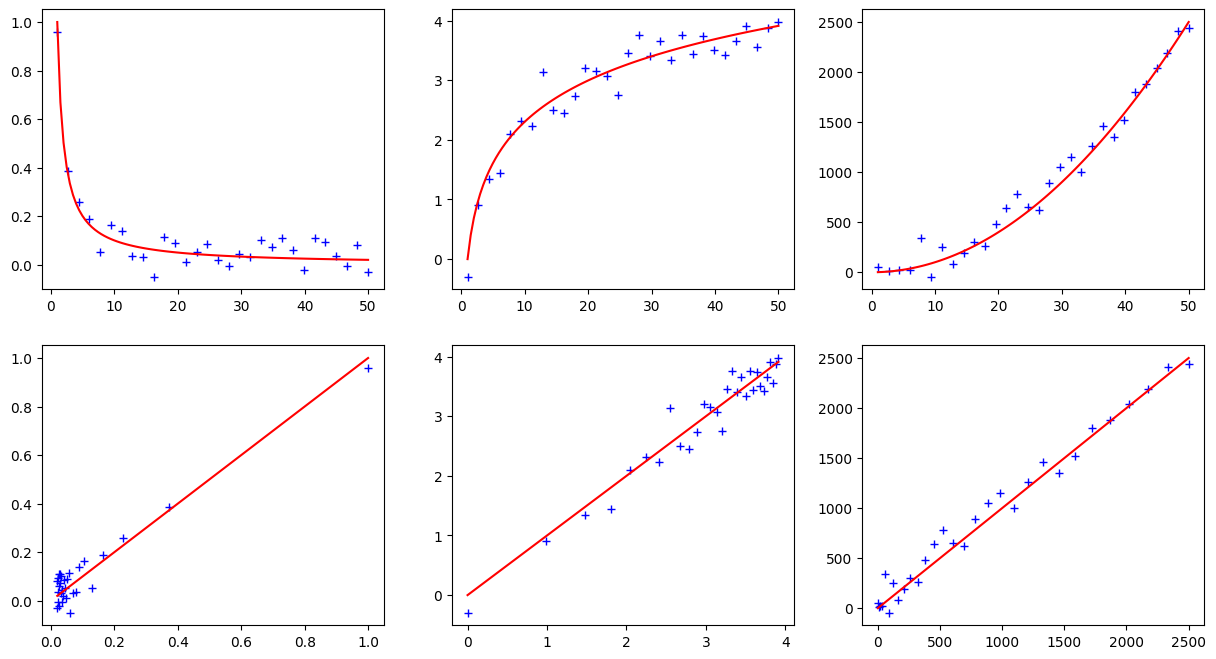

In [81]:
statsmodels_material.illustration_monotonous_functions()

Generic standardization functions exist, such as the [Box-Cox transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) in scipy, but they often require the explanatory variable to take positive values and the interpretation of the relationship becomes less straight-forward.

### Polynomial regression

Let us consider some almost-linearly related data:

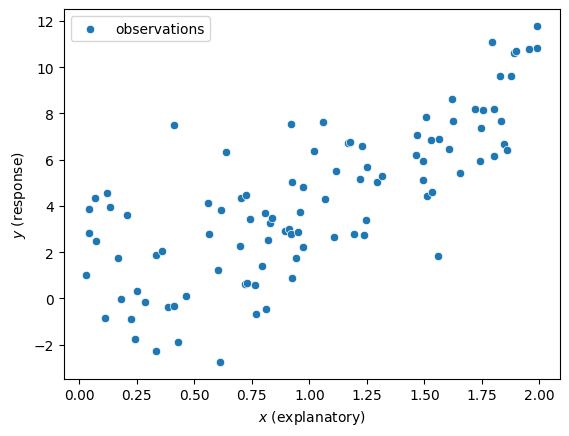

In [82]:
def get_sample(n=100):
    # we will use this code again later in the notebook
    x = np.sort(stats.uniform.rvs(0, 2, size=n))
    y_th = 1 + 0.5 * x + 1.5 * x**2 + 0.3 * x**3
    y = y_th + 2 * stats.norm().rvs(size=x.size)
    return x, y, y_th

np.random.seed(237598)
x, y, y_th = get_sample()

df = pd.DataFrame({'x': x, 'y': y})

ax = sns.scatterplot(x='x', y='y', data=df, label='observations')

#ax.plot(x, y_th, 'r-', label='true relationship') # uncomment

ax.set_xlabel('$x$ (explanatory)')
ax.set_ylabel('$y$ (response)')
ax.legend();

A linear model performs very well, but the structured errors leave no doubt the model is not flexible enough:

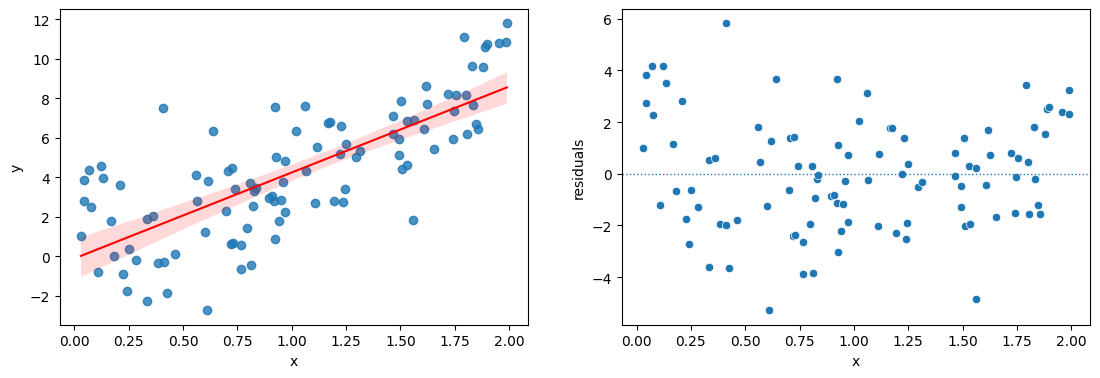

In [83]:
df = pd.DataFrame({'x': x, 'y': y})
linear_model = sm.OLS.from_formula('y ~ x', df).fit()

_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))
sns.regplot(x='x', y='y', data=df, ax=axes[0], line_kws=dict(color='r', linewidth=1.5))
sns.scatterplot(x='x', y='residuals', data=df.assign(residuals=linear_model.resid), ax=axes[1])
axes[1].axhline(0, linestyle=':', linewidth=1);

A flexible approach consists of introducing powers of the explanatory variable, in the shape of multiple data columns.

$$
Y = \left[ X^0, X^1, X^2, ... \right]\beta + \epsilon
$$
or similarly $y_i = \beta_0 + \beta_1 x_i +\beta_2 x_i^2 +... +\epsilon_i$ for all observation $i$.

For example:

In [84]:
augmented_df = df.assign(x2 = x**2)[['y', 'x', 'x2']]
augmented_df.head()

,y,x,x2
0,1.010651,0.030349,0.000921
1,3.869300,0.042248,0.001785
2,2.815199,0.044500,0.001980
3,4.360370,0.069110,0.004776
4,2.486747,0.075106,0.005641


In [85]:
poly2_model = smf.ols('y ~ 1 + x + x2', augmented_df).fit()

As the predictors we plug into the model are synthetic, we do not need to model any interaction between them.

Similarly, we can manually define the `exog` matrix:

In [86]:
X_poly2 = np.stack((np.ones_like(x), x, x*x), axis=1)
poly2_model_bis = sm.OLS(y, X_poly2).fit()

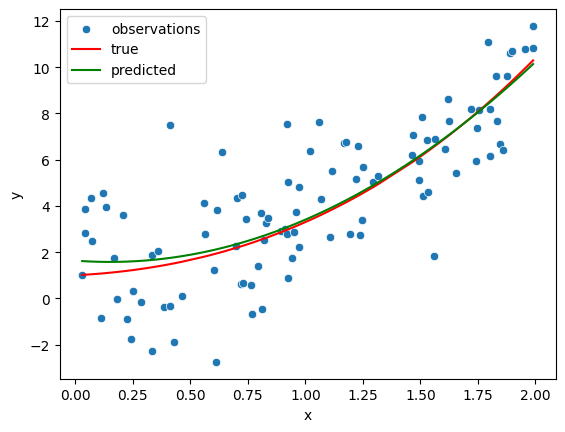

In [87]:
statsmodels_material.illustration_nonlinear_regression(df, y_th, poly2_model, 2)

Polynomial models are flexible enough to closely approximate any function in the neighborhood of a point (think of Taylor series expansions) but, of course, may not be adequate enough as we are modelling a function across an entire domain.

It is also possible to introduce any other non-linear transformation of the explanatory variable as additional terms in the modelling equation or columns in the design matrix. See the following examples in statsmodels documentation: [1](https://www.statsmodels.org/stable/examples/notebooks/generated/predict.html) [2](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html).

### Overfitting

Let us introduce higher order terms:

In [88]:
augmented_again_df = augmented_df.assign(x3=x**3, x4=x**4, x5=x**5, x6=x**6) # yippee!
poly6_model = smf.ols('y ~ 1 + x + x2 + x3 + x4 + x5 + x6', augmented_again_df).fit()

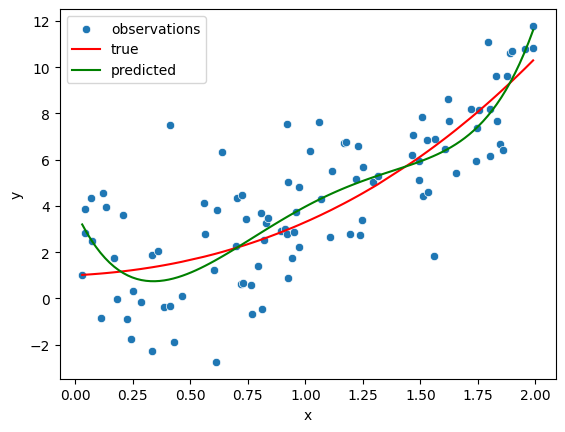

In [89]:
statsmodels_material.illustration_nonlinear_regression(df, y_th, poly6_model, 6)

If we compare the various models, we can observe that more complex models tend to perform better on the training data.

In [90]:
scores = pd.DataFrame(np.array(
    [[model.rsquared, model.rsquared_adj, model.llf, model.aic, model.bic] \
        for model in (linear_model, poly2_model, poly6_model)]),
    index=['1', '2', '6'],
    columns=['R2', 'R2_adjusted', 'log-likelihood', 'AIC', 'BIC'])
scores

,R2,R2_adjusted,log-likelihood,AIC,BIC
1,0.574957,0.570619,-218.166948,440.333896,445.544236
2,0.630454,0.622834,-211.171153,428.342307,436.157817
6,0.663161,0.641430,-206.537608,427.075215,445.311406


Now if we get a new sample from the same population, and compute the coefficient of determination:

In [91]:
x_test, y_test, _ = get_sample()

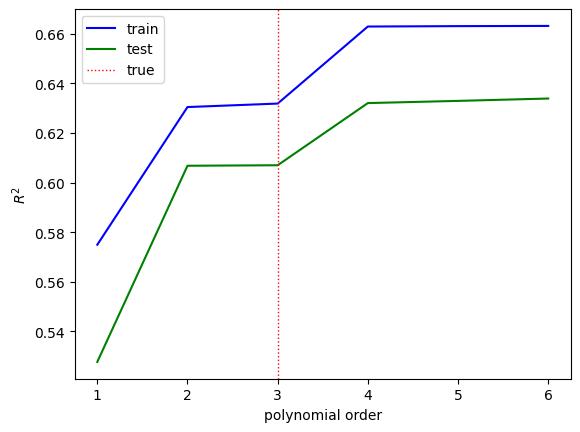

In [92]:
statsmodels_material.illustration_R2_poly(x, y, x_test, y_test)

...the over-complex models perform poorly.

### Model selection

Choosing among models should not rely on data fitness only, especially if we only consider the data used to fit the model.

To choose between models, two strategies:

* model evaluation on test data, *i.e.* a second (sub-)sample drawn from the same population as the data used to fit the model,
    * => `scikit-learn`
* heuristics; for example, model complexity is to be controlled, so that simpler models are favored over complex models.

### Information criteria

[Akaike (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [Bayesian (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) information criteria combine model fitness with the notion of model complexity.

In [93]:
scores

,R2,R2_adjusted,log-likelihood,AIC,BIC
1,0.574957,0.570619,-218.166948,440.333896,445.544236
2,0.630454,0.622834,-211.171153,428.342307,436.157817
6,0.663161,0.641430,-206.537608,427.075215,445.311406


$$
AIC = 2k - 2\log{L}
$$
$$
BIC = k\log{n} - 2\log{L}
$$

with $\log{L}$ the maximum log-likelihood we also met in the OLS summary, and quantifies the goodness-of-fitness.

$k$ is the number of estimated parameters in the model, and $n$ the number of observations.
For $p$ predictors (explaining variables), a linear model's $k=p+2$ because we also estimate an intercept and the error variance.

The likelihood is the probability that the data are generated by the model: $L=P\left(X,y|\mathcal{M}(\theta)\right)$, denoting $\mathcal{M}(\theta)$ the model with parameters $\theta$ (estimated coefficients).

In the case of a linear regression with normally-distributed residuals: $\log{L}\propto -\frac{\sum_i(y_i - \textbf{x}_i^\top\beta)^2}{2\sigma^2}$ with $\beta$ are the regression coefficients.

`OLS` models rely on such a form for the likelihood and that is the reason why we must ensure the residuals are normally distributed.

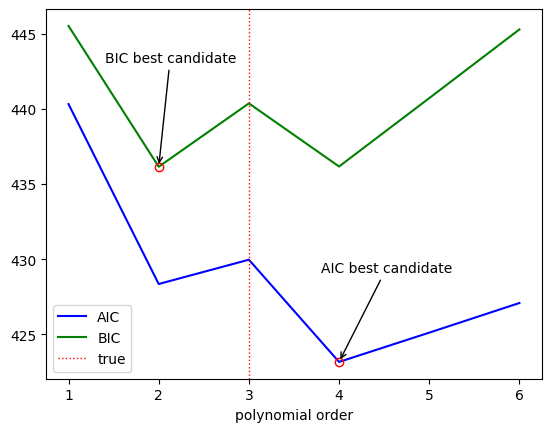

In [94]:
statsmodels_material.illustration_AIC_BIC_poly(x, y)

In a linear model of several factors and many potential interactions terms, the AIC is often used to compare between all the possible models and select a model that exhibits a good trade-off between the likelihood (higher is better) and the number of terms (fewer is better).

## Generalized linear models

What if -- instead of a continuous variable -- our response variable is a binary (or categorical) variable?

### Link functions and families

We need two ingredients.

First, we apply a transformation to the response variable to project its values onto $\mathbb{R}$:

$$
g(y) = \textbf{X}\beta + \epsilon
$$

$g$ is called a *link function*. 

At the same time, a *family* of distribution functions is chosen for $y|\textbf{X}$, to express $\mathbb{E}[y|\textbf{X}] = g^{-1}(\textbf{X}\beta)$. Importantly, the chosen distribution determines the relationship between the mean and variance of $y|\textbf{X}$.

### Example problems

#### Count outcome

\[copying [Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model)\]
Suppose we want to predict how many people will come to some type of outdoor places (*e.g.* beaches) as a function of temperature.

If we observed the attendance in multiple occasions, mostly at temperatures in the 15-35°C range, a fitted linear model could predict impossible values, namely negative attendance, at low temperatures, say 5°C.

A link function could be used to turn the attendance into a variation rate of attendance, so that the attendance can be multiplied or divided as a function of temperature increase/decrease, and never subtracted.

To do so, we need an *exponential response* model with $g=\log$. If $g(y)$ varies linearly with temperature, $y$ will be Poisson distributed.

In [95]:
family = sm.families.Poisson()
# an optional first argument specifies the link function; default is the log link function

#### Odds ratio

Suppose now we want to model the probability of a two-option process, *e.g.* «survives *vs* dies».

A response variable is always quantitative. If we choose it to be the raw probability, we may find situations such that the predicted probability takes a negative value, or falls above $1$.

If we think of the effect of a change in the value of an explanatory variable, this effect better applies to the *odds* of survival, *i.e.* the ratio of survival over death, and again we want the model to make this value vary in a multiplicative way (no subtraction, no addition).

This is a typical application of a *logit* link function, which relies on $y$ following a binomial distribution.

In [96]:
family = sm.families.Binomial()
# the default link function is logit

### Choosing families and link functions

Common choices are:
* $y$ is continuous in $\mathbb{R}$: Gaussian distribution with identity link function (standard linear model)

In [97]:
family = sm.families.Gaussian()
# the default link function is the identity

* $y$ is continuous in $\mathbb{R}^+$: gamma or inverse Gaussian distribution with log link function

In [98]:
family = sm.families.Gamma(sm.families.links.Log())
family = sm.families.InverseGaussian(sm.families.links.Log())
# the log link function must be specified, as the log link function is not default

* $y$ is count data ($y \in \mathbb{N}^+$): Poisson distribution (see above)
* $y$ is $0$ or $1$: binomial distribution with *logit* link function (see above)

### Usage example

In [99]:
df = pd.read_csv('../data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [100]:
model = smf.glm('Survived ~ Age + C(Pclass) + C(Sex)', df, family=sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      709
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.64
Date:                Thu, 30 Oct 2025   Deviance:                       647.28
Time:                        16:07:36   Pearson chi2:                     767.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3587
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.7770      0.401      9.416      0.000       2.991       4.563
C(Pclass)[T.2]    -1.3098      0.278     -4.710      0.000      -1.855      -0.765
C(Pclass)[T.3]    -2.5806      0.281     -9.169      0.000      -3.132      -2.029
C(Sex)[T.male]    -2.5228      0.207    -12.164      0.000      -2.929      -2.116
Age               -0.0370      0.008     -4.831      0.000      -0.052      -0.022
==================================================================================
"""

Some general statistics are not shown in the tables above, but still avaible in the *Generalized Linear Model Regression Results*  object, such as the AIC or BIC:

In [101]:
model.aic

np.float64(657.2831255018241)

Main effects and pairwise differences can be tested using Wald test as already shown.

## Repeated-measures ANOVA and sphericity

Example (one-way): each animal observed multiple times, *e.g.* at different ages; and we are not interested in the putative differences between animals.

$$
SS_{\textrm{total}} = SS_{\textrm{treatment}} + (SS_{\textrm{subject}} + SS_{\textrm{error}})
$$

$$
F^* = \frac{\frac{SS_{\textrm{treatment}}}{k - 1}}{\frac{SS_{\textrm{error}}}{(k-1)(n-1)}}
$$

Designs are balanced.

Let us borrow an example from `pingouin` documentation:

In [102]:
import pingouin as pg

data = pg.read_dataset('rm_anova2')
data.loc[[0,1,10,11,20,21,30,31]]

,Subject,Time,Metric,Performance
0,1,Pre,Product,13
1,2,Pre,Product,12
10,1,Pre,Client,12
11,2,Pre,Client,19
20,1,Pre,Action,17
21,2,Pre,Action,18
30,1,Post,Product,18
31,2,Post,Product,6


In this example, each subject (`Subject`) has undergone all possible measurements, for all levels of the `Time` and `Metric` factors.
As a consequence, the observations for each subject are not independent, and this must be accounted for by the model.

In a standard repeated measures ANOVA, the covariance structure is just assumed to exhibit a property called sphericity.

`Time` and `Metric` are called *within-subject* factors.

statsmodels features [AnovaRM](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.AnovaRM.html) but corrections for departure from sphericity are not implemented and we should first perform a Mauchly's test for sphericity, for example with [pingouin.sphericity](https://pingouin-stats.org/generated/pingouin.sphericity.html):

In [103]:
pg.sphericity(data, dv='Performance', subject='Subject', within=['Time', 'Metric'])

/home/flaurent/Boxes/tumbleweed-1/Projects/misc/scientific_python/.venv/lib64/python3.13/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/flaurent/Boxes/tumbleweed-1/Projects/misc/scientific_python/.venv/lib64/python3.13/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


SpherResults(spher=True, W=np.float64(0.6247989838343564), chi2=np.float64(3.762602454747652), dof=2, pval=np.float64(0.15239168046050933))

In [104]:
from statsmodels.stats import anova
result = anova.AnovaRM(data, depvar='Performance', subject='Subject', within=['Time', 'Metric']).fit()
result.anova_table

,F Value,Num DF,Den DF,Pr > F
Time,33.85228,1.0,9.0,0.000254
Metric,26.95919,2.0,18.0,0.000004
Time:Metric,12.63227,2.0,18.0,0.000373


In contrast, [rm_anova](https://pingouin-stats.org/generated/pingouin.rm_anova.html) from pingouin does implement Greenhouse-Geiser correction.

In [105]:
pg.rm_anova(data, dv='Performance', subject='Subject', within=['Time', 'Metric'])

/home/flaurent/Boxes/tumbleweed-1/Projects/misc/scientific_python/.venv/lib64/python3.13/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/flaurent/Boxes/tumbleweed-1/Projects/misc/scientific_python/.venv/lib64/python3.13/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Time,828.816667,1,9,828.816667,33.85228,0.000254,0.000254,0.254011,1.000000
1,Metric,1365.233333,2,18,682.616667,26.95919,0.000004,0.000005,0.359335,0.969103
2,Time * Metric,224.433333,2,18,112.216667,12.63227,0.000373,0.001708,0.084420,0.727166


Mixed effects models are increasingly popular and preferred over the standard repeated measures ANOVA, especially because sphericity simply cannot be expected from the data in most cases.